In [ ]:
#Download Libraries
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install torch
!pip install yfinance
!pip install transformers
!pip install scikit-learn

In [ ]:
#Import modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import zipfile
import torch.nn as nn
import datetime
import yfinance as yf
import shutil
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#Clean tweet
def cleanTweets(data):

	data['tweetClean'] = data['Text'].str.lower()

	## FIX HYPERLINKS
	data['tweetClean'] = data['tweetClean'].replace(r'https?:\/\/.*[\r\n]*', ' ',regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'www.*[\r\n]*', ' ',regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('https', '', regex=False)


	## FIX INDIVIDUAL SYMBOLS
	data['tweetClean'] = data['tweetClean'].str.replace(': ', ' ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(', ', ' ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('. ', ' ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('[;\n~]', ' ', regex=True)

	data['tweetClean'] = data['tweetClean'].str.replace("[]'â€¦*™|]", '', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('[[()!?"]', '', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('_', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('w/', ' with ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('f/', ' for ', regex=False)


	## FIX EMOJIS
	data['tweetClean'] = data['tweetClean'].str.replace(':)', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(':-)', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(':(', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(':-(', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('0_o', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(';)', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('=^.^=', '', regex=False)


	## FIX % SYMBOL
	data['tweetClean'] = data['tweetClean'].str.replace('%', ' percent ', regex=False)


	## FIX & SYMBOL
	data['tweetClean'] = data['tweetClean'].str.replace(' & ', ' and ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('&amp', ' and ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('&gt', ' greater than ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('cup&handle', 'cup and handle', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('c&h', 'cup and handle', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('head&shoulders', 'head and shoulders', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('h&s', 'head and shoulders', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('point&figure', 'point and figure', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('p&f', 'point and figure', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('s&p', 'SP500', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('q&a', 'question and answer', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('&', ' and ', regex=False)


	## FIX USER TAGS AND HASTAGS
	data['tweetClean'] = data['tweetClean'].str.replace('@[a-z0-9]+', '', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('#[a-z0-9]+', '', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('@', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('#', '', regex=False)


	## FIX EMBEDDED COMMAS AND PERIODS
	data['tweetClean'] = data['tweetClean'].replace(r'([a-z]),([a-z])', r'\1 \2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]),([0-9])', r'\1\2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])[+]+', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(',', '', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('u.s.', ' us ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('\.{2,}', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([a-z])\.([a-z])', r'\1 \2', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('pdating', 'updating', regex=False)
	data['tweetClean'] = data['tweetClean'].replace(r'([a-z])\.', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'\.([a-z])', r' \1', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(' . ', ' ', regex=False)


	## FIX + SYMBOL
	data['tweetClean'] = data['tweetClean'].replace(r'[+]([0-9])', r'positive \1', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('c+h', 'cup and handle', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('h+s', 'head and shoulders', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('cup+handle', 'cup and handle', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' + ', ' and ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('+ ', ' ', regex=False)
	data['tweetClean'] = data['tweetClean'].replace(r'([a-z])[+]([a-z])', r'\1 and \2', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('+', '', regex=False)




	## FIX - SYMBOL
	data['tweetClean'] = data['tweetClean'].replace(r'([a-z])[-]+([a-z])', r'\1 \2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([a-z]) - ([a-z])', r'\1 to \2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]) -([0-9\.])', r'\1 to \2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r' [-]([0-9])', r' negative \1', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])-([0-9\.])', r'\1 to \2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]) - ([0-9\.])', r'\1 to \2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9a-z])-([0-9a-z])', r'\1 \2', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('[-]+[>]', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(' [-]+ ', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('-', ' ', regex=False)



	## FIX $ SYMBOL
	data['tweetClean'] = data['tweetClean'].str.replace('[$][0-9\.]', ' dollars ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('$', '', regex=False)


	## FIX = SYMBOL
	data['tweetClean'] = data['tweetClean'].str.replace('=', ' equals ', regex=False)


	## FIX / SYMBOL
	data['tweetClean'] = data['tweetClean'].str.replace('b/c', ' because ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('b/out', ' break out ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('b/o', ' break out ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace('p/e', ' pe ratio ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' [/]+ ', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(' 1/2 ', ' .5 ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 1/4 ', ' .25 ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 3/4 ', ' .75 ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 1/3 ', ' .3 ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 2/3 ', ' .6 ', regex=False)

	data['tweetClean'] = data['tweetClean'].str.replace('[/]{2,}', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([a-z])/([a-z])', r'\1 and \2', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('[0-9]+/[0-9]+/[0-9]+', '', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]{3,})/([0-9\.]{2,})', r'\1 to \2', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]{2,})/([0-9\.]{3,})', r'\1 to \2', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('[a-z0-9]+/[a-z0-9]+', ' ', regex=True)

	data['tweetClean'] = data['tweetClean'].str.replace('/', '', regex=False)


	## FIX < > SYMBOLS
	data['tweetClean'] = data['tweetClean'].str.replace('[<]+ ', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('<', ' less than ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' [>]+', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('>', ' greater than ', regex=False)


	## FIX : SYMBOL
	data['tweetClean'] = data['tweetClean'].str.replace('[0-9]+:[0-9]+am', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('[0-9]+:[0-9]', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(':', ' ', regex=False)


	## FIX UNITS
	data['tweetClean'] = data['tweetClean'].str.replace('user ', ' ', regex=False)

	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]+)dma', r'\1 displaced moving average ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'dma([0-9]+)', r'\1 displaced moving average ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]+)sma', r'\1 simple moving average ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'sma([0-9]+)', r'\1 simple moving average ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]+)ema', r'\1 expontential moving average ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'ema([0-9]+)', r'\1 expontential moving average ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9]+)ma', r'\1 moving average ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'ma([0-9]+)', r'\1 moving average ', regex=True)

	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])mos', r'\1 months ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])minute', r'\1 minute ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])minutes', r'\1 minutes ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])min', r'\1 minute ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])mins', r'\1 minutes ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])day', r'\1 day ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])days', r'\1 days ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])wk', r'\1 week ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(' wk ', ' week ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' wknd ', ' weekend ', regex=False)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])wks', r'\1 weeks ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])hours', r'\1 hours ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])hour', r'\1 hour ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])yr', r'\1 year ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])yrs', r'\1 years ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(' yr', ' year ', regex=False)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])am', r'\1 am ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])pm', r'\1 pm ', regex=True)

	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])est', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])ish', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9 ])pts', r'\1 points ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])x', r'\1 times ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])th', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])rd', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])st', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])nd', r'\1 ', regex=True)

	data['tweetClean'] = data['tweetClean'].str.replace('mrkt', 'market', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' vol ', ' volume ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' ptrend', ' positive trend ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' ppl', ' people ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' pts', ' points ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' pt', ' point ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' l(ol){1,}', ' laugh ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('imho', ' in my opinion ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace('prev ', 'previous ', regex=True)


	data['tweetClean'] = data['tweetClean'].str.replace(' 1q', ' first quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 2q', ' second quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 3q', ' third quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 4q', ' fourth quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' q1', ' first quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' q2', ' second quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' q3', ' third quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' q4', ' fourth quarter ', regex=False)
	data['tweetClean'] = data['tweetClean'].str.replace(' 10q ', ' form 10 ', regex=False)

	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])million', r'\1 million ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])mil', r'\1 million ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.replace(' mil ', ' million ', regex=False)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])billion', r'\1 billion ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])cents', r'\1 cents ', regex=True)

	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])3d', r'\1 3 dimensional ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])gb', r'\1 3 gigabytes ', regex=True)



	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])c', r'\1 calls ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])y', r'\1 year ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])p', r'\1 puts ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])d', r'\1 days ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])h', r'\1 hour ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])s', r'\1 ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])k1', r'\1 thousand ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])k', r'\1 thousand ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])m', r'\1 million ', regex=True)
	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])b', r'\1 billion ', regex=True)


	data['tweetClean'] = data['tweetClean'].replace(r'([0-9])([a-z])', r'\1 \2', regex=True)

	## FIX EXTRA SPACES AND ENDING PUNCTUATION
	data['tweetClean'] = data['tweetClean'].str.replace(' +', ' ', regex=True)
	data['tweetClean'] = data['tweetClean'].str.strip(' .!?,)(:-')


	return data

In [ ]:
rawTweets = pd.read_csv('/content/stock_data.csv')

In [ ]:
#Make the data
tweets = cleanTweets(rawTweets)
tweets.drop('Text', axis = 1, inplace = True)
tweets['Sentiment'] = tweets['Sentiment'].replace(-1,0)

/usr/local/lib/python3.10/dist-packages/pandas/core/strings/object_array.py:158: FutureWarning: Possible nested set at position 1
  pat = re.compile(pat, flags=flags)


In [ ]:
#Split the data. Using the default settings
X_train, X_test, y_train, y_test = train_test_split(tweets['tweetClean'].values, tweets['Sentiment'].values, random_state = 42)

In [ ]:
# Prepare the Bert NLP model tokenizer to encode tweets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encode the tweets for Bert model
def preprocessing_for_bert(data):
    input_ids = []
    attention_masks = []

    # For each tweet
    for line in data:
        # encode the data. Return input encoding and attention mask
        encoding = tokenizer.encode_plus(
                text=line, # data to process
                add_special_tokens=True,
                padding='max_length',
                max_length = MAX_LEN,
                truncation=True,
                return_tensors="pt",
                return_attention_mask=True
                )

        # add the encodings to the list
        input_ids.append(encoding.get('input_ids'))
        attention_masks.append(encoding.get('attention_mask'))

    # return the lists as tensors
    input_ids = torch.concat(input_ids)
    attention_masks = torch.concat(attention_masks)

    return input_ids, attention_masks


# Use this to determine max length for encoding
encoded = [tokenizer.encode(sent, add_special_tokens=True) for sent in tweets['tweetClean'].values]
MAX_LEN = max([len(sent) for sent in encoded])
print('Max length: ', MAX_LEN)


# Encode the train and test data for Bert
X_train_inputs, X_train_masks = preprocessing_for_bert(X_train)
X_test_inputs, X_test_masks = preprocessing_for_bert(X_test)

# Get the train and test labels
y_train_labels = torch.tensor(y_train)
y_test_labels = torch.tensor(y_test)


# Set batch size to 16. recommended 16 or 32 depending on GPU size
batch_size = 16

# Randomize the train data and define dataloader for model training
train_data = TensorDataset(X_train_inputs, X_train_masks, y_train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Randomize the test data and define dataloader for model testing
test_data = TensorDataset(X_test_inputs, X_test_masks, y_test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Max length:  53
torch.Size([4343, 53]) torch.Size([4343, 53]) torch.Size([4343])
torch.Size([1448, 53]) torch.Size([1448, 53]) torch.Size([1448])


In [ ]:
# Define the Bert NLP Classifier
class BertClassifier(nn.Module):
    def __init__(self, freeze=False):
        super(BertClassifier, self).__init__()

        # Define the neurons for the final layer. I can expriment with changing the hidden layer to 100, and see the results. Kept that for further study
        input_layer = 768 # BERT recommended
        hidden_layer = 50
        output_layer = 2

        # Use the pretrained Bert model for first section of NN
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Define a final layer to attach to the Bert model for custom classification
        self.classifier = nn.Sequential(
            nn.Linear(input_layer, hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, output_layer))

        # Freeze the model from updating
        if freeze:
            for param in self.bert.parameters():
                param.requires_grad = False

    # Return classification from Bert model
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        h_cls = outputs[0][:, 0, :]
        logits = self.classifier(h_cls)

        return logits

In [ ]:
# Set random seed for repeatability
torch.manual_seed(1)
torch.cuda.manual_seed_all(1)
np.random.seed(1)

# Check if GPU is available and assign device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Initialize Bert Classifier
model = BertClassifier(freeze=False)

# Send model to device (GPU if available)
model.to(device)

# Define model hyperparameters. Epochs can be increased to 10, but for this data instance the model overfits after fourth epoch
epochs = 5
steps = len(train_dataloader) * epochs
learning_rate = 5e-5
epsilon = 1e-8

# Define Adam optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

# Define scheduler for training the optimizer
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=steps)

# Define cross entropy loss function
loss_function = nn.CrossEntropyLoss()

# For the number of epochs
for e in range(epochs):
    # Assign model to train
    model.train()

    # Intialize loss to zero
    train_loss = 0

    # For each batch
    for batch in train_dataloader:
        # Get batch inputs, masks and labels
        batch_inputs, batch_masks, batch_labels = batch

        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        # Reset the model gradient
        model.zero_grad()

        # Get classification of encoded values
        logits = model(batch_inputs, batch_masks)

        # Calculate loss based on predictions and known values
        loss = loss_function(logits, batch_labels)

        # Add loss to the running total
        train_loss += loss.item()

        # Update the model weights based on the loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    # Calculate the average loss over batch
    train_loss /= len(train_dataloader)

    # Assign the model to evaluate
    model.eval()

    # Initialize losses
    test_loss = 0
    test_acc = 0

    # For each batch
    for batch in test_dataloader:
        # Get encoding inputs, masks and labels
        batch_inputs, batch_masks, batch_labels = batch

        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)
        batch_labels = batch_labels.to(device)

        # Predict the input values without updating the model
        with torch.no_grad():
            logits = model(batch_inputs, batch_masks)

        # Calculate the loss
        loss = loss_function(logits, batch_labels)
        test_loss += loss.item()

        # Convert predictions to 0 and 1
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate accuracy of model on test data
        accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
        test_acc += accuracy

    # Calculate average loss and accuracy per each batch
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

    # Print epoch information
    print('Epoch: %d  |  Train Loss: %1.5f  |  Test Loss: %1.5f  |  Test Accuracy: %1.2f'%(e+1, train_loss, test_loss, test_acc))

# Save model
torch.save(model.state_dict(), 'stock_BERT_model.pt')

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch: 1  |  Train Loss: 0.53556  |  Test Loss: 0.42365  |  Test Accuracy: 79.26
Epoch: 2  |  Train Loss: 0.32208  |  Test Loss: 0.49638  |  Test Accuracy: 81.52
Epoch: 3  |  Train Loss: 0.16490  |  Test Loss: 0.71458  |  Test Accuracy: 81.80
Epoch: 4  |  Train Loss: 0.06352  |  Test Loss: 0.88549  |  Test Accuracy: 82.01
Epoch: 5  |  Train Loss: 0.03196  |  Test Loss: 0.93294  |  Test Accuracy: 81.94


In [ ]:
def extract_all_in_directory(directory):
    # Get a list of all files in the directory
    files = os.listdir(directory)

    # Iterate through each file in the directory
    for file in files:
        # Check if the file is a zip file
        if file.endswith('.zip'):
            file_path = os.path.join(directory, file)

            # Create a directory with the same name as the zip file (without extension)
            extract_dir = os.path.splitext(file_path)[0]
            os.makedirs(extract_dir, exist_ok=True)

            # Create a ZipFile object
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all contents into the created directory
                zip_ref.extractall(extract_dir)

            print(f"Extracted contents from {file} to {extract_dir}.")

In [ ]:
# Create a new directory. Name it 'companydata'. Import the data of stocks inside this directory as zip files
# Extract all the files
extract_all_in_directory('/content/companydata')

Extracted contents from regn_2016_06_15_13_53_08.xlsx.zip to /content/companydata/regn_2016_06_15_13_53_08.xlsx.
Extracted contents from mat_2016_06_15_13_17_09.xlsx.zip to /content/companydata/mat_2016_06_15_13_17_09.xlsx.
Extracted contents from csx_2016_06_15_12_28_34.xlsx.zip to /content/companydata/csx_2016_06_15_12_28_34.xlsx.
Extracted contents from txn_2016_06_15_14_03_07.xlsx.zip to /content/companydata/txn_2016_06_15_14_03_07.xlsx.
Extracted contents from lbtyk_2016_06_15_13_15_16.xlsx.zip to /content/companydata/lbtyk_2016_06_15_13_15_16.xlsx.
Extracted contents from disca_2016_06_15_12_32_37.xlsx.zip to /content/companydata/disca_2016_06_15_12_32_37.xlsx.
Extracted contents from wfm_2016_06_15_14_08_18.xlsx.zip to /content/companydata/wfm_2016_06_15_14_08_18.xlsx.
Extracted contents from atvi_2016_06_15_14_34_02.xlsx.zip to /content/companydata/atvi_2016_06_15_14_34_02.xlsx.
Extracted contents from tmus_2016_06_15_13_58_03.xlsx.zip to /content/companydata/tmus_2016_06_15_13

In [ ]:
# Get the list of stock data to convert
# Takes about 1hr to run on colab GPU
allFiles = os.listdir('/content/companydata')

files = [file for file in allFiles if not file.endswith('.zip')]
# for each stock files
for x in range(len(files)):

    # open the excel file on the Stream sheet
    stock = pd.read_excel('/content/companydata/'+files[x] + '/export_dashboard_' + files[x], sheet_name='Stream')

    # Assign the ticker name as a column
    stock['Ticker'] = files[x].split('_')[0]

    # Convert string date times to datetime
    stock['Date'] = pd.to_datetime(stock['Date'])
    stock['Hour'] = stock['Hour'].apply(lambda t: pd.Timedelta(hours=int(t[:2]), minutes=int(t[3:])))
    stock['Datetime'] = stock['Date'] + stock['Hour']

    # Rename column that holds the tweets content
    stock.rename(columns = {'Tweet content':'Text'}, inplace = True)

    # Pre process the tweet content
    stock = cleanTweets(stock) # This might take time since the dataset is big. There are a million tweets for some compnay

    # Keep relevant columns
    stock = stock[['Tweet Id', 'Ticker', 'Datetime', 'Text', 'tweetClean', 'Favs', 'RTs', 'Followers', 'Following', 'Is a RT']]

    # Fill NAs in Favs, RTs, Followers and Following with 0
    stock = stock.fillna(0)

    # Encode processed tweets for Bert NLP model
    stock_inputs, stock_masks = preprocessing_for_bert(stock['tweetClean'].values)

    # Put stock data in PyTorch dataloader for processing
    stock_data = TensorDataset(stock_inputs, stock_masks)
    stock_sampler = RandomSampler(stock_data)
    stock_dataloader = DataLoader(stock_data, sampler=stock_sampler, batch_size=batch_size)

    # Assign model to evaluate
    model.eval()

    predictions = []

    # For each batch
    for batch in stock_dataloader:
        # Get encoded inputs and masks
        batch_inputs, batch_masks = batch

        # Send variables to device (GPU if available)
        batch_inputs = batch_inputs.to(device)
        batch_masks = batch_masks.to(device)

        # Predict classes with Bert for given inputs
        with torch.no_grad():
            logits = model(batch_inputs, batch_masks)

        # Convert predictions to 0s and 1s
        preds = torch.argmax(logits, dim=1).flatten()
        predictions.append(preds)

    # Combine all batch predictions
    predictions = torch.cat(predictions).cpu().numpy()

    # Add predictions to stock dataframe
    stock['Sentiment'] = predictions

    # save predictions as new csv
    os.makedirs('/content/result/'+files[x], exist_ok=True)
    stock.to_csv('/content/result/'+files[x] +'/stock_data_sentiment.csv', index=False)

    # Show stock names as they are completed
    print(files[x].split('_')[0], '- completed')

chtr - completed
lmck - completed
adp - completed
ulta - completed
fox - completed
qcom - completed
amzn - completed
expe - completed
alxn - completed
qvca - completed
trip - completed
mar - completed
mnst - completed
lrcx - completed
hsic - completed
sbux - completed
pcar - completed
isrg - completed
sbac - completed
pypl - completed
fb - completed
mat - completed
regn - completed
akam - completed
lmca - completed
vrtx - completed
nxpi - completed
mu - completed
lltc - completed
gild - completed
ntes - completed
txn - completed
wfm - completed
googl - completed
msft - completed
mdlz - completed
vod - completed
mxim - completed
intu - completed
orly - completed
bidu - completed
bbby - completed
foxa - completed
disck - completed
goog - completed
aapl - completed
inct - completed
ilmn - completed
ebay - completed
myl - completed
ea - completed
atvi - completed
khc - completed
vrsk - completed
payx - completed
wdc - completed
csco - completed
cost - completed
dltr - completed
dish - comp

In [ ]:
model.eval()

predictions = []

for batch in test_dataloader:
    batch_inputs, batch_masks, batch_labels = batch

    batch_inputs = batch_inputs.to(device)
    batch_masks = batch_masks.to(device)
    batch_labels = batch_labels.to(device)

    with torch.no_grad():
        logits = model(batch_inputs, batch_masks)


    preds = torch.argmax(logits, dim=1).flatten()
    predictions.append(preds)

predictions = torch.cat(predictions).cpu().numpy()

negatives = np.where(y_test==0)[0]
TNs = np.where( (y_test==0) & (y_test==predictions) )[0]
print(f'Ratio of true negative to the total number of negative samples : {len(TNs)/len(negatives)}')

positives = np.where(y_test==1)[0]
TPs = np.where( (y_test==1) & (y_test==predictions) )[0]
print(f'Ratio of true positives to the total number of positive samples : {len(TPs)/len(positives)}')

Ratio of true negative to the total number of negative samples : 0.7223300970873786
Ratio of true positives to the total number of positive samples : 0.872454448017149


In [ ]:
# Get all of the stock files to process
files = os.listdir('/content/result')

# Initialize new dataframe to hold stock data
stocks = pd.DataFrame()

# For each stock to process
for x in range(len(files)):
    # Some tickers may be delisted, use try/except to avoid errors if ticker does not exist in yFinance
    try:
        # Assign current file name
        filename = files[x]

        # Read csv file for current ticker
        data = pd.read_csv('/content/result/'+filename+'/stock_data_sentiment.csv')

        # Convert string time to datetime
        data['Datetime'] = pd.to_datetime(data['Datetime'])

        # Convert 0 sentiment to -1
        data.loc[data['Sentiment']==0, 'Sentiment'] = -1

        # Initialize Weights and Tweet numbers
        data['Tweets'] = 1
        data['Weight'] = 1

        # Determine the mean and standard deviation of the number of followers a given user has for a given tweet
        # This ensures tweets with less tweets per day are treated equally
        data['Followers_Mean'] = data['Followers'].rolling(10000, min_periods=1).mean()
        data['Followers_Std'] = data['Followers'].rolling(10000, min_periods=1).std()
        data['Followers_Std'] = data['Followers_Std'].fillna(data['Followers_Std'].values[1])

        # weight tweets from users with higher follower counts more heavily. Calculate based on mean and standard deviation gates
        data.loc[ (data['Followers']>=data['Followers_Mean']) & (data['Followers'] < (data['Followers_Mean']+data['Followers_Std'])), 'Weight'] += 1
        data.loc[ (data['Followers']>=(data['Followers_Mean']+data['Followers_Std'])) & (data['Followers'] < (data['Followers_Mean']+data['Followers_Std']*2)), 'Weight'] += 2
        data.loc[data['Followers']>=(data['Followers_Mean']+data['Followers_Std']*2), 'Weight'] += 3

        # Determine the mean and standard deviation of the number of re-tweets a given user has for a given tweet
        # This ensures tweets with less tweets per day are treated equally
        data['RTs_Mean'] = data['RTs'].rolling(10000, min_periods=1).mean()
        data['RTs_Std'] = data['RTs'].rolling(10000, min_periods=1).std()
        data['RTs_Std'] = data['RTs_Std'].fillna(data['RTs_Std'].values[1])

        # Weight tweets with more re-tweests more heavily. Calculate based on mean and standard deviation gates
        data.loc[ (data['RTs']>=data['RTs_Mean']) & (data['RTs'] < (data['RTs_Mean']+data['RTs_Std'])), 'Weight'] += 1
        data.loc[ (data['RTs']>=(data['RTs_Mean']+data['RTs_Std'])) & (data['RTs'] < (data['RTs_Mean']+data['RTs_Std']*2)), 'Weight'] += 2
        data.loc[data['RTs']>=(data['RTs_Mean']+data['RTs_Std']*2), 'Weight'] += 3

        # multiply the sentiment score by the individual weigth
        data['Sentiment_Weighted'] = data['Sentiment']*data['Weight']

        # Group the stock data by months and days
        data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()

        # Reassign the ticker name that was lost after grouping
        data['Ticker'] = filename.split('_')[0]

        # Reassign date based on index values of month and day
        data['Date'] = pd.to_datetime([ str(x)+'/'+str(y)+'/2016' for (x,y) in data.index.values ])+datetime.timedelta(days=1)

        # Drop the index
        data = data.reset_index(drop=True)

        # Divide the sentiment by the total number of tweets
        data['Sentiment_Weighted'] /= data['Tweets']

        # Get the rolling average of the sentiment and tweet volume
        data['Sentiment_MA'] = data['Sentiment_Weighted'].rolling(3, min_periods=1).mean()
        data['Tweets_MA'] = data['Tweets'].rolling(3, min_periods=1).mean()

        # Get the starting date and ending date to extract stock prices
        start_date = data['Date'].min()
        end_date = data['Date'].max()+datetime.timedelta(days=2)

        # Download stock price data for given range of tweets
        prices = yf.download(tickers=filename.split('_')[0], start=start_date, end=end_date).reset_index()

        # Calculate percent change based on stock price changes
        prices['Percent_Change'] = (prices['Adj Close'].pct_change()*100).shift(-1)

        # Bin percent changes by amount lost/gained by stock
        prices['Percent_Change_Bin'] = pd.cut(prices['Percent_Change'], [-100, 0, 2, 100], labels=[0, 1, 2])

        # Combine the stock sentiment data and the pricing data
        data = data.merge(prices, on='Date', how='left')

        # Remove excess columns
        data = data[['Ticker', 'Date', 'Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA', 'Adj Close', 'Percent_Change', 'Percent_Change_Bin']]

        # Drop missing values for days without pricing information
        data = data.dropna().reset_index(drop=True)

        # Save stock sentiment and pricing data to csv
        data.to_csv('/content/result/' + filename + '/stock_data_inputs.csv', index=False)

        # Add ticker data to the main data set
        stocks = pd.concat([stocks, data])

        # Print status of ticker
        print(filename.split('_')[0], '- Completed')

    # If the ticker is not in yFinance
    except Exception as e:
        # Print error message
        print(filename.split('_')[0], '-', e)


# Save data for all stocks to csv
stocks.to_csv('combined_stock_inputs.csv', index=False)

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
chtr - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LMCK']: Exception('%ticker%: No timezone found, symbol may be delisted')


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


lmck - Completed
[*********************100%%**********************]  1 of 1 completed
adp - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ulta - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FOX']: Exception("%ticker%: Data doesn't exist for startDate = 1459137600, endDate = 1466136000")



fox - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
qcom - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
amzn - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
expe - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ALXN']: Exception('%ticker%: No timezone found, symbol may be delisted')



alxn - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['QVCA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-28 00:00:00 -> 2016-06-17 00:00:00)')



qvca - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
trip - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
mar - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
mnst - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
lrcx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
hsic - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
sbux - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
pcar - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
isrg - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
sbac - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
pypl - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FB']: Exception('%ticker%: No timezone found, symbol may be delisted')
<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()



fb - Completed
[*********************100%%**********************]  1 of 1 completed
mat - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
regn - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
akam - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LMCA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)')



lmca - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
vrtx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
nxpi - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
mu - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LLTC']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-28 00:00:00 -> 2016-06-17 00:00:00)')



lltc - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
gild - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ntes - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
txn - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WFM']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-11 00:00:00 -> 2016-06-18 00:00:00)')



wfm - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
googl - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
msft - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
mdlz - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
vod - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MXIM']: Exception('%ticker%: No timezone found, symbol may be delisted')



mxim - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
intu - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
orly - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
bidu - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BBBY']: Exception('%ticker%: No timezone found, symbol may be delisted')


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


bbby - Completed
[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FOXA']: Exception("%ticker%: Data doesn't exist for startDate = 1459224000, endDate = 1466222400")



foxa - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DISCK']: Exception('%ticker%: No timezone found, symbol may be delisted')



disck - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
goog - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
aapl - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
inct - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ilmn - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ebay - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MYL']: Exception('%ticker%: No timezone found, symbol may be delisted')



myl - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ea - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
atvi - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
khc - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
vrsk - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
payx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
wdc - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
csco - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
cost - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
dltr - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
dish - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ENDP']: Exception('%ticker%: No timezone found, symbol may be delisted')



endp - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
amat - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SYMC']: Exception('%ticker%: No timezone found, symbol may be delisted')



symc - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
wba - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VIAB']: Exception('%ticker%: No timezone found, symbol may be delisted')



viab - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
lbtyk - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
csx - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CELG']: Exception('%ticker%: No timezone found, symbol may be delisted')
<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()



celg - Completed
[*********************100%%**********************]  1 of 1 completed
jd - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
swks - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
fast - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
avgo - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ntap - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['YHOO']: Exception('%ticker%: No timezone found, symbol may be delisted')



yhoo - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
cmcsa - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
rost - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PCLN']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)')



pcln - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LVNTA']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-29 00:00:00 -> 2016-06-18 00:00:00)')



lvnta - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
bmrn - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SNDK']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2016-03-28 00:00:00 -> 2016-06-18 00:00:00)')



sndk - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
tsco - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CERN']: Exception('%ticker%: No timezone found, symbol may be delisted')



cern - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
aal - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
srcl - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
amgn - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
nvda - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ctsh - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
chkp - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
nflx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
stx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
adsk - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
nclh - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:


ERROR:yfinance:['XLNX']: Exception('%ticker%: No timezone found, symbol may be delisted')


xlnx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
incy - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
tsla - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['DISCA']: Exception('%ticker%: No timezone found, symbol may be delisted')



disca - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
esrx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
ca - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
tmus - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['FISV']: Exception('%ticker%: No timezone found, symbol may be delisted')



fisv - Completed
[*********************100%%**********************]  1 of 1 completed

<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()
ERROR:yfinance:
1 Failed download:


ERROR:yfinance:['CTRP']: Exception('%ticker%: No timezone found, symbol may be delisted')
<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


ctrp - Completed
[*********************100%%**********************]  1 of 1 completed
lrcx - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
adbe - Completed


<ipython-input-13-9293bd759bdd>:53: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby([data.Datetime.dt.month, data.Datetime.dt.day]).sum()


[*********************100%%**********************]  1 of 1 completed
lbtya - Completed


Invested in a losing stock : 19.81%




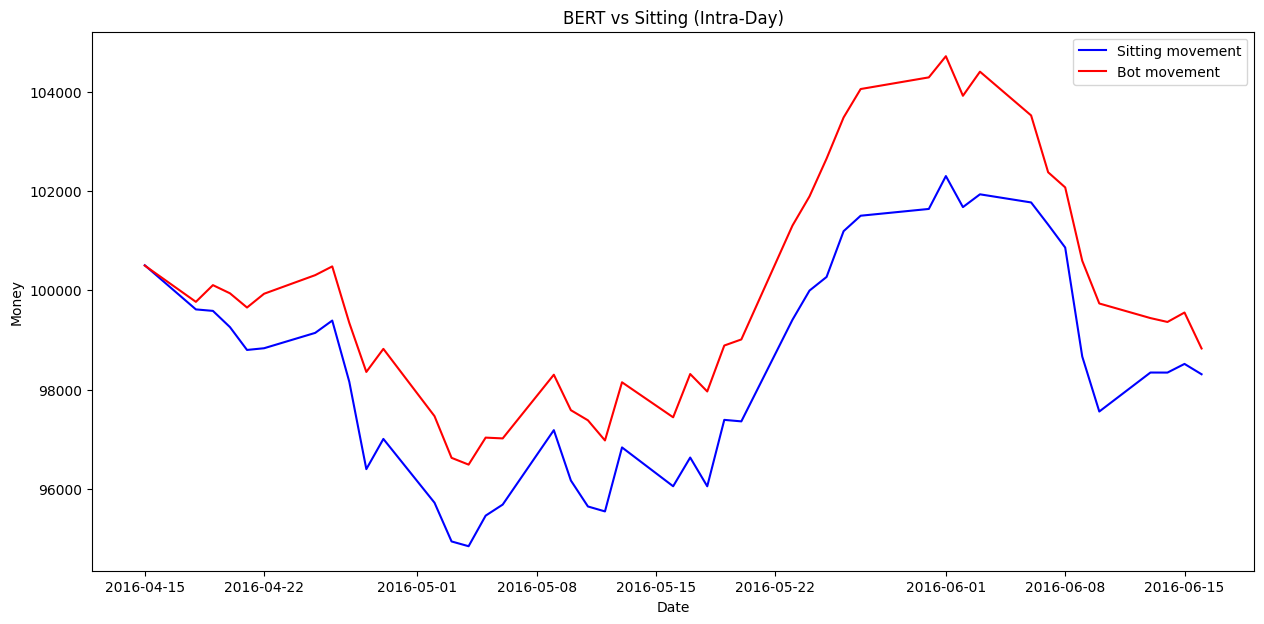

Sitting Investment: 98309.33 ( -1.69 % )
Bot Trading: 98828.69 ( -1.17 % )


In [ ]:
# Sort values in stock sentiment/pricing data by date and ticker name
stocks = stocks.sort_values(['Date', 'Ticker'])

# Use first 2 months of data as test data
d_train = stocks.loc[stocks['Date'] < datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)

# Use last 2-3 months as test data
d_test = stocks.loc[stocks['Date'] >= datetime.datetime(year=2016, month=4, day=15)].reset_index(drop=True)

# Remove extra columns from train data
X_train = d_train[['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']].values
y_train = d_train['Percent_Change_Bin'].values

# Remove extra solumns from test data
X_test = d_test[['Sentiment_Weighted', 'Sentiment_MA', 'Tweets', 'Tweets_MA']].values
y_test = d_test['Percent_Change_Bin'].values



# Define random forest classifier
model = RandomForestClassifier(random_state=1)

# Train model with training data
model.fit(X_train, y_train)

# Predict the test data
preds = model.predict(X_test)

# Print the percent of predictions that resulted in investing in a losing stock
print(f'Invested in a losing stock : {len(np.where( (preds>0) & (y_test==0) )[0])/len(preds)*100:.2f}%')
print('\n')

# Add predictions to test dataset
d_test['Prediction'] = preds

# Initialize starting capital to test model effectiveness
bot_capital = 100000
sitting_capital = 100000

# Add capital as first data points
bots = [bot_capital]
sitting= [sitting_capital]

# Get unique dates
dates = d_test['Date'].sort_values().unique()

# For each date
for date in dates:
    # filter dataframe to date
    temp = d_test[d_test['Date']==date]

    # Calculate profit from investing equal parts to all tickers in timeframe
    sitting_capital = sitting_capital + ((sitting_capital/len(temp)) * (temp['Percent_Change']/100)).sum()

    # Calculate profit from using the Twitter bot to determine what stocks to invest in
    temp = temp[temp['Prediction'] > 0]
    bot_capital = bot_capital + ((bot_capital/len(temp)) * (temp['Percent_Change']/100)).sum()

    # Keep track of the account totals ove time
    sitting.append(sitting_capital)
    bots.append(bot_capital)


# Plot the accounts balances over time
plt.figure(figsize=(15,7))
plt.plot(dates, sitting[1:], c='b', label='Sitting movement')
plt.plot(dates, bots[1:], c='r', label='Bot movement')
plt.title('BERT vs Sitting (Intra-Day)')
plt.xlabel('Date')
plt.ylabel('Money')
plt.legend()
plt.show()

# Show the return from each account over time
print('Sitting Investment:', round(sitting[-1],2), '(', round((sitting[-1]-sitting[0])/sitting[0]*100,2), '% )')
print('Bot Trading:', round(bots[-1],2), '(', round((bots[-1]-bots[0])/bots[0]*100,2), '% )')


In [ ]:
result = '/content/result'

# Replace 'output_zip_name.zip' with the desired name for the output zip file
results = '/content/results.zip'

# Create a zip file of the folder
shutil.make_archive(results.split('.')[0], 'zip', result)

# Print a message indicating that the zip file has been created
print(f"Folder '{result}' has been zipped to '{results}'.")

Folder '/content/result' has been zipped to '/content/results.zip'.
